# Remove image background with Robust PCA 

**Grupo** <br />
Rafael Guimarães <br />
Bruno Monteiro   <br />
Harrison Santos  <br />


**Disciplina:** Métodos Numéricos <br />
**Professor:** Paulo Ribeiro

De acordo com [[1]](https://pt.wikipedia.org/wiki/An%C3%A1lise_de_componentes_principais)  A Análise de Componentes Principais (ACP) ou Principal Component Analysis (PCA) é um procedimento matemático que utiliza uma transformação ortogonal (ortogonalização de vetores) para converter um conjunto de observações de variáveis possivelmente correlacionadas num conjunto de valores de variáveis linearmente não correlacionadas chamadas de componentes principais. O número de componentes principais é sempre menor ou igual ao número de variáveis originais. Os componentes principais são garantidamente independentes apenas se os dados forem normalmente distribuídos (conjuntamente). O PCA é sensível à escala relativa das variáveis originais. Dependendo da área de aplicação, o PCA é também conhecido como transformada de Karhunen-Loève (KLT) discreta, transformada de Hotelling ou decomposição ortogonal própria (POD).

Nesse notebook, iremos desenvolver uma aplicação do Algoritmo PCA.

In [1]:
import moviepy.editor as mpe
from glob import glob
import sys, os
import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TOL = 1.0e-8

In [3]:
video = mpe.VideoFileClip("data/highwayII_raw.AVI")

Nosso dataset está disponível nesse link [[2]](http://cvrr.ucsd.edu/aton/shadow/index.html) na sessão **Raw Movies**

In [4]:
video

In [5]:
video.subclip(0,50).ipython_display(width=300)

t:   3%|▎         | 23/750 [00:00<00:03, 229.15it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [6]:
video.duration

33.33

## Métodos Auxiliáres

Os métodos abaixo estão disponíveis no link [[3]](https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb) 

**Descrição dos Métodos Auxiliáres**

1. Definir uma matriz de dados a partir do video.
~~~python
def create_data_matrix_from_video(clip, k=5, scale=50):
~~~

2. Muda as cores do video para escala de cinza. 
~~~python
def rgb2gray(rgb):
~~~

3. Temos dois métodos para plotar as imagens.
~~~python
def plt_images(M, A, E, index_array, dims, filename=None):
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):    
~~~

In [7]:
def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
                      scale).flatten() for i in range(k * int(clip.duration))]).T

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [9]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [10]:
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

# Carregar e visualizar os dados

In [11]:
scale = 25   # Adjust scale to change resolution of image
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

In [12]:
M = create_data_matrix_from_video(video, 100, scale)
# M = np.load("high_res_surveillance_matrix.npy")

In [13]:
print(dims, M.shape)

(60, 80) (4800, 3300)


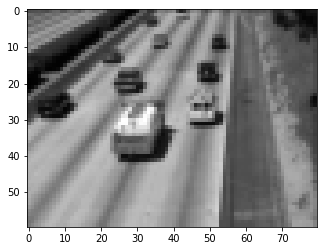

In [14]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

De acordo com [3],  como a função

~~~python
def create_data_matrix_from_video(clip, k=5, scale=50):
~~~ 
é um pouco lenta, salvaremos nossa matriz. Em geral, sempre que houver etapas lentas de pré-processamento, é uma boa idéia salvar os resultados para uso futuro.

In [15]:
np.save("low_res_surveillance_matrix.npy", M)

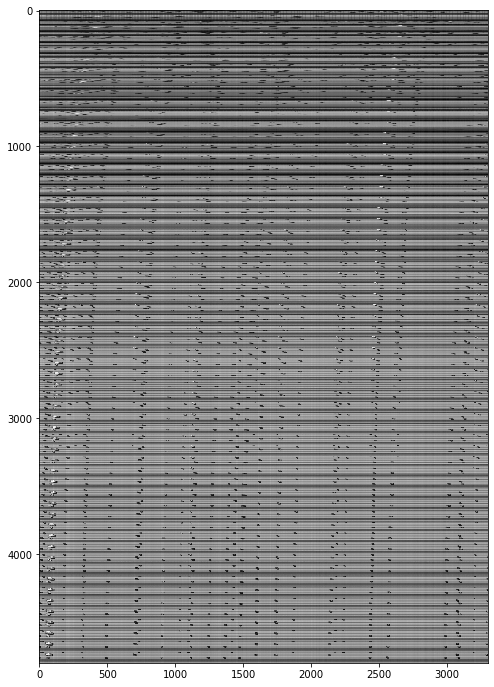

In [16]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

In [17]:
plt.imsave(fname="image1.jpg", arr=np.reshape(M[:,140], dims), cmap='gray')

# Usando SVD

In [18]:
from sklearn import decomposition

In [19]:
u, s, v = decomposition.randomized_svd(M, 2)

In [20]:
u.shape, s.shape, v.shape

((4800, 2), (2,), (2, 3300))

In [21]:
low_rank = u @ np.diag(s) @ v

In [22]:
low_rank.shape

(4800, 3300)

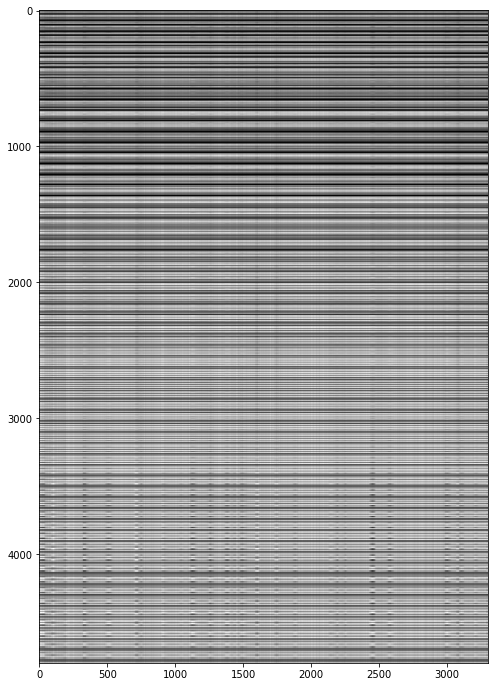

In [23]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

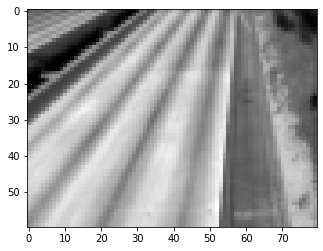

In [24]:
plt.imshow(np.reshape(low_rank[:,140], dims), cmap='gray');

Nesse Caso, podemos ver aqui apenas nosso Background.

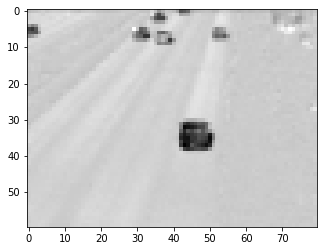

In [25]:
plt.imshow(np.reshape(M[:,550] - low_rank[:,550], dims), cmap='gray');

Nesse Caso, podemos ver aqui apenas nossos carros, ou figuras em movomento.

Como foi demosntrado no link [3] ao lidar com conjuntos de dados de alta dimensão, geralmente aproveitamos o fato de que os dados têm baixa dimensionalidade intrínseca para aliviar a maldição da dimensionalidade e da escala (talvez esteja em um subespaço de baixa dimensão ou em um coletor de baixa dimensão ) A análise de componentes principais é útil para eliminar dimensões. O PCA clássico busca a melhor estimativa de classificação

para isso, 

Usaremos a biblioteca **Fast Randomized PCA** do Facebook.

In [26]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

In [27]:
TOL=1e-9
MAX_ITERS=3

In [28]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [29]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [30]:
def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

In [31]:
def norm_op(M): return _svd(M, 1)[1][0]

In [32]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [33]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

# Resultados

In [34]:
m, n = M.shape
round(m * .05)

240

In [35]:
L, S, examples =  pcp(M, maxiter=5, k=10)

rank sv: 1
error:  0.1422911075383834
rank sv: 166
error:  0.047668506228045936
rank sv: 51
error:  0.007249362880615821
rank sv: 216
error:  0.0006341449149061061
rank sv: 381
error:  2.6620798299427684e-05


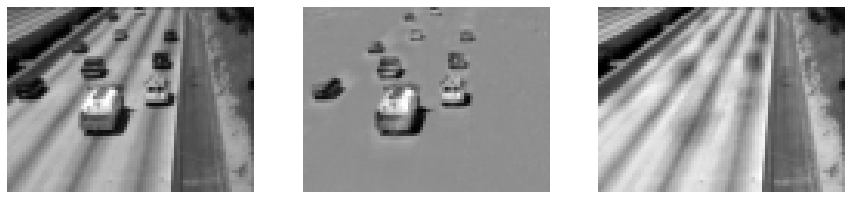

In [37]:
f = plt_images(M, S, L, [140], dims)

In [38]:
np.save("high_res_L.npy", L)
np.save("high_res_S.npy", S)

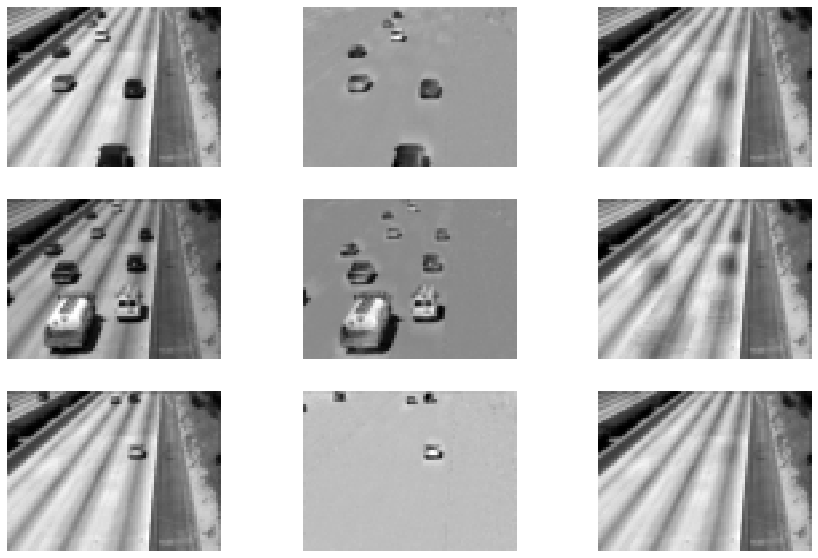

In [39]:
f = plt_images(M, S, L, [0, 100, 1000], dims)